In [3]:
import os
import math
from czifile import CziFile
import nrrd
import numpy
import skimage
from skimage.exposure import rescale_intensity, adjust_log, adjust_sigmoid, equalize_adapthist
from skimage.filters import threshold_otsu
from skimage.morphology import label, convex_hull_image, medial_axis, erosion, disk
from skimage.transform import rotate, downscale_local_mean
from skimage.util import crop
import matplotlib
from matplotlib.pyplot import imshow

In [5]:
image = CziFile("S:\\DBIO_Rihel_Lab\\Josh\\20230321_sert_tph\\SCR\\F1_SCR.czi")
img_array = image.asarray()
img_ch1 = numpy.squeeze(img_array[0,0,0,0,0,0,0])
img_ch2 = numpy.squeeze(img_array[0,0,0,0,0,0,1])
img_ch1 = numpy.flip(img_ch1,0)
img_ch2 = numpy.flip(img_ch2,0)
print(img_ch1.shape)
%xdel img_array

(360, 1920, 1920)


In [6]:
image.shape

(1, 1, 1, 1, 1, 1, 3, 1, 360, 1920, 1920, 1)

In [7]:
print(img_ch1.dtype)
ch1_cl = img_ch1
ch2_cl = img_ch2
print(ch1_cl.shape)

uint16
(360, 1920, 1920)


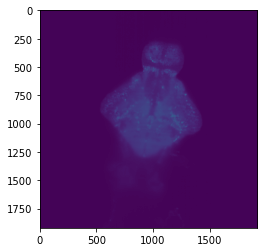

In [9]:
matplotlib.pyplot.imshow(ch1_cl[220],vmax=5000)

C:\Users\BiancoLab\AppData\Local\Temp\ipykernel_6948\372404213.py:4: FutureWarning: `selem` is a deprecated argument name for `erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  test1 = skimage.morphology.erosion(test1,selem = disk(11))


-48.01278750418334


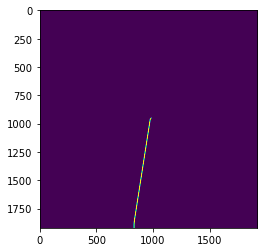

In [10]:
test = ch1_cl[int(ch1_cl.shape[0]/2.5)]
thresh = skimage.filters.threshold_otsu(test)
test1 = test > thresh/2.3
test1 = skimage.morphology.erosion(test1,selem = disk(11))
final = skimage.morphology.convex_hull_image(test1)
skel,dist = skimage.morphology.medial_axis(final,return_distance=True)
ones = numpy.nonzero(skel>0)
first=(ones[0][0],ones[1][0])
last = numpy.unravel_index(numpy.argmax(dist),dist.shape)
deltay = last[1] - first[1]
deltax = last[0] - first[0]
ori = math.degrees(math.atan2(deltay, deltax))
print(ori)
matplotlib.pyplot.imshow(skel,vmin=0,vmax=0.1)

In [11]:
rot_ch1=[]
rot_ch2=[]

for slices in ch1_cl:
    temp = skimage.transform.rotate(slices,90-ori,resize=True,preserve_range=True)
    rot_ch1.append(temp)
    %xdel temp
    
for slices in ch2_cl:
    temp = skimage.transform.rotate(slices,90-ori,resize=True,preserve_range=True)
    rot_ch2.append(temp)
    %xdel temp
    
%xdel img_ch1
%xdel img_ch2

MemoryError: Unable to allocate 56.1 MiB for an array with shape (2711, 2711) and data type float64

In [ ]:
rot_ch1 = numpy.asarray(rot_ch1,dtype=numpy.uint16)
rot_ch2 = numpy.asarray(rot_ch2,dtype=numpy.uint16)
print(rot_ch1.dtype)
print(rot_ch1.shape)

In [ ]:
ch1 = skimage.util.crop(rot_ch1, ((0, 0), (int((rot_ch1.shape[1]-1280)/2),int((rot_ch1.shape[1]-1280)/2)), (int((rot_ch1.shape[2]-1900)/2),int((rot_ch1.shape[2]-1900)/2))), copy=False)
ch2 = skimage.util.crop(rot_ch2, ((0, 0), (int((rot_ch2.shape[1]-1280)/2),int((rot_ch2.shape[1]-1280)/2)), (int((rot_ch2.shape[2]-1900)/2),int((rot_ch2.shape[2]-1900)/2))), copy=False)
ch1_r = skimage.transform.downscale_local_mean(ch1, (1, 2, 2),cval=0)
ch2_r = skimage.transform.downscale_local_mean(ch2, (1, 2, 2),cval=0)
# ch2_r = skimage.exposure.rescale_intensity(ch2_r)
ch1_r = skimage.exposure.adjust_gamma(ch1_r,gamma=1,gain=2)
ch1_r = skimage.exposure.rescale_intensity(ch1_r)
ch2_ds = skimage.util.img_as_ubyte(ch2_r)
ch1_ds = skimage.util.img_as_ubyte(ch1_r)

print(ch1_ds.dtype)
print(ch1_ds.shape)
%xdel ch1
%xdel ch2
%xdel ch1_r
%xdel ch2_r

In [ ]:
nrrd.write('D:\\lightsheetdata\\2020-31-10 DAPI gad sst1 npy\\brain1_gad_sst1_01.nrrd',ch1_ds,index_order = 'C',compression_level=1)
nrrd.write('D:\\lightsheetdata\\2020-31-10 DAPI gad sst1 npy\\brain1_gad_sst1_02.nrrd',ch2_ds,index_order = 'C',compression_level=1)

In [ ]:
%reset